In [74]:
import numpy as np

class MomentumGradientDescent:
    def __init__(
        self,
        learning_rate=0.001,
        momentum=0.9,
        max_iters=1e4,
        epsilon=1e-8,
        batch_size=32,
        record_history=False,
    ):
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.max_iters = max_iters
        self.record_history = record_history
        self.epsilon = epsilon
        self.batch_size = batch_size
        self.prev_delta_w = None
        if record_history:
            # to store the weight history for visualization
            self.w_history = []

    def run(self, gradient_fn, x, y, w):
        grad = np.inf
        t = 1
        term_cond = 0
        N, D = x.shape
        self.prev_delta_w = np.zeros(w.shape)

        for i in range(0, N, self.batch_size):
            if x.ndim == 1:
                batch_x = x[i:i + self.batch_size]
            else:
                batch_x = x[i:i + self.batch_size, :]
            if y.ndim == 1:
                batch_y = y[i:i + self.batch_size]
            else:
                batch_y = y[i:i + self.batch_size, :]
            # compute the gradient with present weight
            grad = gradient_fn(batch_x, batch_y, w)
            delta_w = self.get_delta_w(grad)
            # weight update step
            w = w - self.learning_rate * delta_w
            if self.record_history:
                self.w_history.append(w)
        return w, grad

    def get_delta_w(self, grad):
        beta = self.momentum
        delta_w = beta * self.prev_delta_w + (1 - beta) * grad
        self.prev_delta_w = delta_w

        return delta_w

In [75]:
import numpy as np

# from the given Colab code
logistic = lambda z: 1./ (1 + np.exp(-z))  

class SoftmaxRegression:

    def __init__(self, add_bias=True, regularization_penalty=0.):
        self.add_bias = add_bias
        self.regularization_penalty = regularization_penalty
            
    def fit(self, x, y, C, optimizer, w0):
        if x.ndim == 1:
            x = x[:, None]
        if self.add_bias:
            N = x.shape[0]
            x = np.column_stack([x,np.ones(N)])
        N,D = x.shape
        
        def to_onehot(a):
            return np.eye(C)[a]
        
        def gradient(x, y, w):
            N, D = x.shape
            # yh: N x C
            yh = self.softmax(np.dot(x, w))
            # both are N x C
            yh = to_onehot(self.to_classlabel(yh))
            y = to_onehot(y)
            
            grad = np.dot(x.T, yh - y) / N
            if self.regularization_penalty > 0:
                if self.add_bias:
                    grad[:-1,:] += self.regularization_penalty * w[:-1,:]    # don't penalize the intercept
                else:
                    grad += self.regularization_penalty * w
            return grad
        
        # run the optimizer to get the optimal weights
        self.w, self.grad = optimizer.run(gradient, x, y, w0) 
        return self
    
    def softmax(self, z):
        # to prevent overflow/underflow
        z = z - np.max(z, axis=-1, keepdims=True)
        return (np.exp(z.T) / np.sum(np.exp(z), axis=1)).T

    def to_classlabel(self, z):
        return z.argmax(axis=1)
    
    def predict(self, x):
        if self.add_bias:
            x = np.column_stack([x,np.ones(N)])
        # convert from 1D to 2D
        x = np.reshape(x, (1, -1))
        yh = self.softmax(np.dot(x, self.w))
        return self.to_classlabel(yh)[0]
        

In [76]:
import math

def k_fold_splitter(fold, dataset):
    """
    Returns 2 datasets (training and validation)
    """
    start = math.floor(fold*(dataset.shape[0]/5))
    end = math.floor((fold+1)*(dataset.shape[0]/5))

    training = np.delete(dataset, slice(start, end-1), axis=0)
    validation = dataset[start:end-1]

    return training, validation

def termination_model_accuracy(x, y, C, learning_rate, momentum, batch_size, term_condition, max_iters=1000):
    """
    Calculate max accuracy each itteration to see if we've reached a termination condition
    """
    j = 0
    T = 0
    N, D = x.shape
    prev_weight =  np.random.rand(D,C)
    prev_accuracy = 0.00
    grad = np.inf
    epsilon = 1e-8
    """
    Ensure that: grad is non-zero, we have not reached max itterations and that our termination condition hasn't been reached
    """
    while np.linalg.norm(grad) > epsilon and j < max_iters and T < term_condition:
        accuracies = []
        for fold_num in range(5):
            train_data, validation_data = k_fold_splitter(fold_num, x)
            train_labels, validation_labels = k_fold_splitter(fold_num, y)
            optimizer = MomentumGradientDescent(
                learning_rate=learning_rate, 
                momentum=momentum, 
                batch_size=batch_size, 
                max_iters=max_iters,
            )
            model = SoftmaxRegression(add_bias=False)

            model.fit(train_data, train_labels, C, optimizer, prev_weight)
            prev_weight = model.w
            grad = model.grad

            num_misclassified = 0
            # calculate the accuracy
            for i in range(len(validation_data)):
                prediction = model.predict(validation_data[i, :])
                if prediction != validation_labels[i]:
                    num_misclassified += 1
            misclassification_rate = num_misclassified / len(validation_labels)
            # print("Fold {} itteration {} accuracy {}".format(fold_num, j, 1-misclassification_rate))
            accuracies.append(1 - misclassification_rate)

        cur_accuracy = np.average(accuracies)
        
        if cur_accuracy > prev_accuracy:
            prev_accuracy =cur_accuracy
            T = 0
        else:
            T += 1
        # print(cur_accuracy, end=", ")
        j += 1

    # print("\n\nAfter {} itterations, termination condition was reached with an accuracy of: {}".format(j, prev_accuracy))
    return prev_accuracy


In [77]:
# store hyper-parameter values here for use below
digits_learning_rate = 0.14003
digits_momentum = 0.99
digits_batch_size = 897

wine_learning_rate = 0.14003
wine_momentum = 0.696
wine_batch_size = 178

In [87]:
from sklearn.datasets import load_digits
from sklearn.datasets import load_wine
%matplotlib inline
import matplotlib.pyplot as plt

digits = load_digits()
x, y = digits.data, digits.target

C = 10
digits_accuracies = []
term_condtions = np.linspace(1, 100, 10)

for term_condtion in term_condtions:
    # using the hyper-parameter values obtained from grid search
    accuracy = termination_model_accuracy(x, y, C, digits_learning_rate, digits_momentum, digits_batch_size, term_condtion)
    digits_accuracies.append(accuracy)

# plot for accuracy vs. learning rate on digits dataset
plt.plot(term_condtions, digits_accuracies, '.')
plt.title('Accuracy vs. Termination Condition (Digits Dataset)')
plt.xlabel('termination condition')
plt.ylabel('accuracy')
plt.show()


0.11831281803893498, 0.15960069093229176, 0.18136505812234482, 0.1880518510449573, 0.21092731205552356, 0.24440484897527268, 0.2806679012153561, 0.32640948631362726, 0.3682575745786713, 0.4000653584600301, 0.43243802617450705, 0.4564276933132071, 0.4826597780924667, 0.501635517654565, 0.5261931809340036, 0.5406980905992749, 0.5563218748541106, 

KeyboardInterrupt: 

, termination condition was reached with an accuracy of: 0.7070588235294117
0.2, 0.32571428571428573, 0.13714285714285715, 0.32571428571428573, 0.13714285714285715, 0.33714285714285713, 0.13714285714285715, 0.33714285714285713, 0.13142857142857142, 0.16, 0.32571428571428573, 0.13714285714285715, 0.32571428571428573, 0.13714285714285715, 0.4, 0.5428571428571429, 0.32571428571428573, 0.14285714285714285, 0.32571428571428573, 0.3581512605042017, 0.32571428571428573, 0.18369747899159666, 0.32571428571428573, 0.3815126050420168, 0.32571428571428573, 0.2939495798319328, 0.32571428571428573, 0.3870588235294118, 0.32571428571428573, 0.3579831932773109, 0.32571428571428573, 0.31109243697478994, 0.32571428571428573, 0.36386554621848743, 0.32571428571428573, 0.31680672268907567, 0.33142857142857146, 0.21142857142857144, 0.47815126050420165, 0.19529411764705884, 0.44537815126050423, 0.3485714285714286, 0.3554621848739496, 0.3151260504201681, 0.3134453781512605, 0.5798319327731092, 0.45932773109243

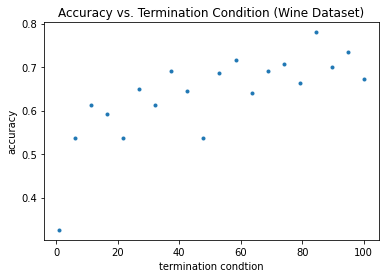

In [86]:
wine = load_wine()
x, y = wine.data, wine.target

C = 3
wine_accuracies = []
term_condtions = np.linspace(1, 100, 20)

for term_condtion in term_condtions:
    # using the hyper-parameter values obtained from grid search
    accuracy = termination_model_accuracy(x, y, C, wine_learning_rate, wine_momentum, wine_batch_size, term_condtion)
    wine_accuracies.append(accuracy)

# plot for accuracy vs. learning rate on wine dataset
plt.plot(term_condtions, wine_accuracies, '.')
plt.title('Accuracy vs. Termination Condition (Wine Dataset)')
plt.xlabel('termination condtion')
plt.ylabel('accuracy')
plt.show()